In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators

In [3]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 50.0
T = 1/beta
gamma = 5.0
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

# Convergence of the BCF

In [4]:
g_compare, w_compare = debye_spectral_density.get_debye_coefficients(10000, T, gamma, eta)

In [9]:
N_steps = 1000
taus = np.linspace(0, duration, N_steps)
N_terms = [13, 14, 15, 16, 17, 18, 19, 20]
alphas = np.empty((len(N_terms), N_steps), dtype=complex)
for i, N in enumerate(N_terms):
    g, w = debye_spectral_density.get_debye_coefficients(N, T, gamma, eta, mode='pade')
    alphas[i, :] = bath_correlation_function.alpha(taus, g, w)
alphas_compare = bath_correlation_function.alpha(taus, g_compare, w_compare)

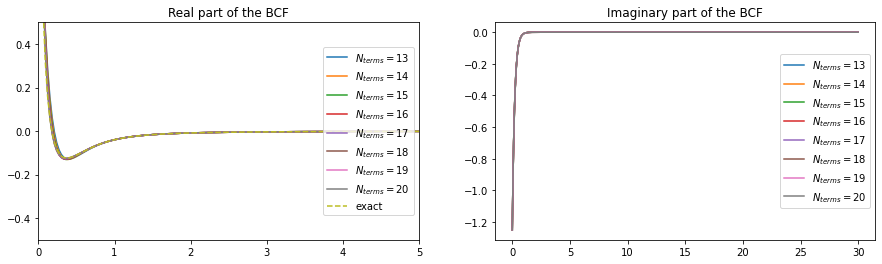

In [10]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
for i, N in enumerate(N_terms):
    axarray[0].plot(taus, np.real(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
    axarray[1].plot(taus, np.imag(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
axarray[0].plot(taus, np.real(alphas_compare), "--", label="exact")
axarray[0].legend(loc="right")
axarray[0].set_title("Real part of the BCF")
axarray[0].set_xlim(0, 5)
axarray[0].set_ylim(-0.5, 0.5)
axarray[1].legend(loc="right")
axarray[1].set_title("Imaginary part of the BCF")
plt.show()

# HOMPS: Convergence in N_steps (without noise, RK4)

In [7]:
N_steps_list = [1500, 3000, 6000, 10000, 20000, 30000, 40000, 50000]
N_trunc = 9
N_terms = 13
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')

In [8]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
}

In [12]:
def plot_progress(psis, index):
    for i in range(index):
        sigma_zs = compute_exp_val_nonlinear(psis_N_steps[i], sigma_z)
        plt.plot(np.linspace(0, duration, N_steps_list[i]), sigma_zs, label="N_steps = "+str(N_steps_list[i]))
    plt.legend()
    plt.show()

Computing N_steps = 1500
took 105.57829523086548 seconds.


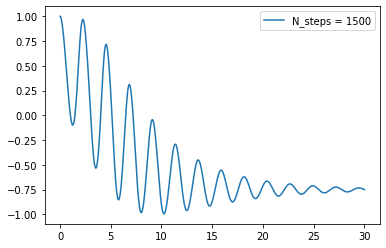

Computing N_steps = 3000
took 168.23002886772156 seconds.


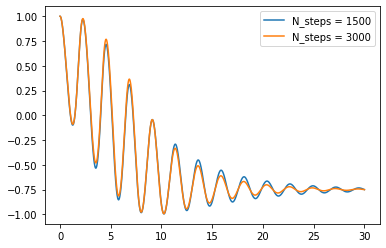

Computing N_steps = 6000
took 250.64137601852417 seconds.


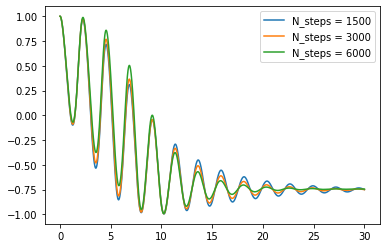

Computing N_steps = 10000
took 310.0486686229706 seconds.


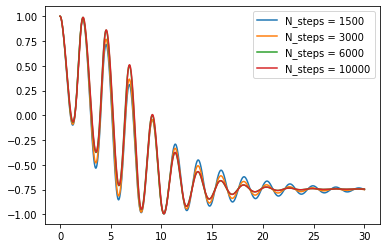

Computing N_steps = 20000
took 530.8834362030029 seconds.


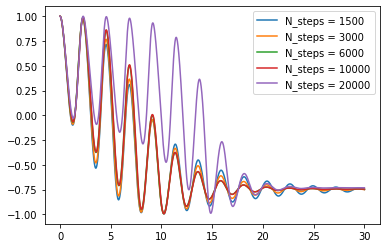

Computing N_steps = 30000
took 747.4471843242645 seconds.


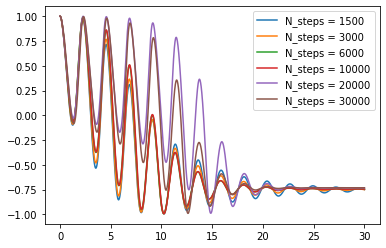

Computing N_steps = 40000
took 1212.9897882938385 seconds.


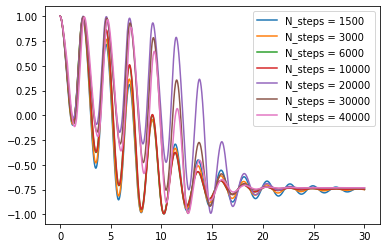

Computing N_steps = 50000
took 1398.419756412506 seconds.


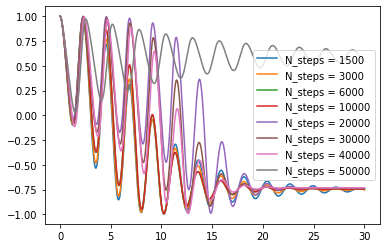

In [13]:
psis_N_steps = []

for i, N_steps in enumerate(N_steps_list):
    print("Computing N_steps =", N_steps)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_steps.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")
    plot_progress(psis_N_steps, i+1)

# HOMPS: Convergence in N_steps (without noise, TDVP)

In [14]:
N_steps_list_TDVP = [1500, 3000, 6000, 10000, 20000, 30000, 40000, 50000]
N_trunc = 9
N_terms = 13
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')

In [15]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'TDVP2',
}

In [16]:
def plot_progress(psis, index):
    for i in range(index):
        sigma_zs = compute_exp_val_nonlinear(psis[i], sigma_z)
        plt.plot(np.linspace(0, duration, N_steps_list_TDVP[i]), sigma_zs, label="N_steps = "+str(N_steps_list_TDVP[i]))
    plt.legend()
    plt.show()

Computing N_steps = 1500
took 170.02127385139465 seconds.


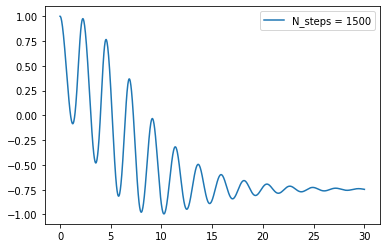

Computing N_steps = 3000
took 189.49998450279236 seconds.


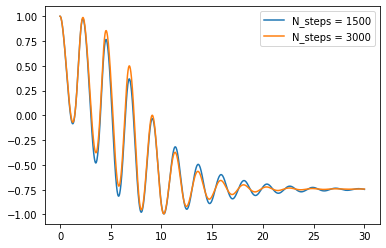

Computing N_steps = 6000
took 380.2767815589905 seconds.


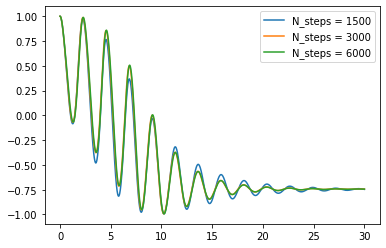

Computing N_steps = 10000
took 511.30192160606384 seconds.


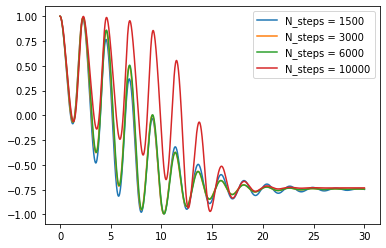

Computing N_steps = 20000
took 879.193724155426 seconds.


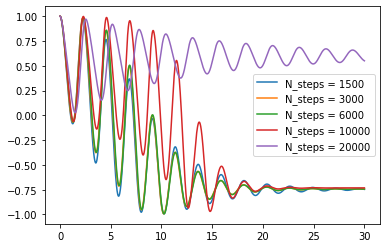

Computing N_steps = 30000
took 1282.5695202350616 seconds.


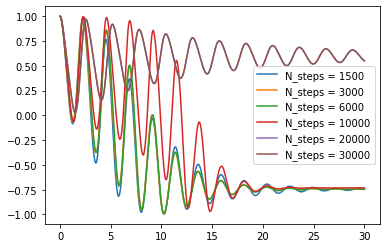

Computing N_steps = 40000
took 1677.2898800373077 seconds.


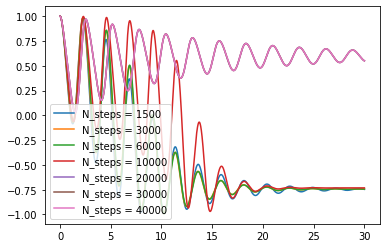

Computing N_steps = 50000
took 1943.782371520996 seconds.


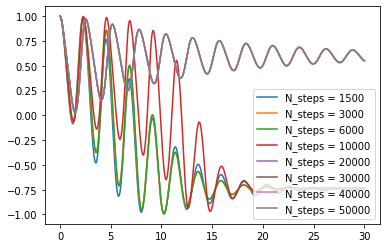

In [17]:
psis_N_steps_TDVP = []

for i, N_steps in enumerate(N_steps_list):
    print("Computing N_steps =", N_steps)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_steps_TDVP.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")
    plot_progress(psis_N_steps_TDVP, i+1)

## Comparing RK4 with TDVP

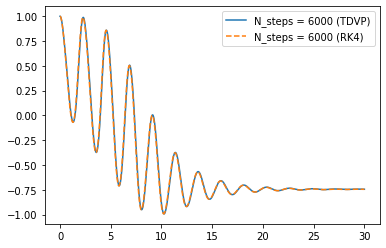

In [29]:
i = 2
sigma_zs = compute_exp_val_nonlinear(psis_N_steps_TDVP[i], sigma_z)
plt.plot(np.linspace(0, duration, N_steps_list_TDVP[i]), sigma_zs, label="N_steps = "+str(N_steps_list_TDVP[i])+" (TDVP)")
sigma_zs = compute_exp_val_nonlinear(psis_N_steps[i], sigma_z)
plt.plot(np.linspace(0, duration, N_steps_list[i]), sigma_zs, "--", label="N_steps = "+str(N_steps_list[i])+" (RK4)")

plt.legend()
plt.show()

# HOMPS: Convergence in N_trunc (without noise)

In [46]:
N_steps = 2000
N_trunc_list = [2, 5, 9, 10, 15]
N_terms = 15
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')

In [49]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
}

In [50]:
psis_N_trunc = []

for N_trunc in N_trunc_list:
    print("Computing N_trunc =", N_trunc)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_trunc.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_trunc = 2
took 34.15470790863037 seconds.
Computing N_trunc = 5
took 55.12074303627014 seconds.
Computing N_trunc = 9
took 96.628342628479 seconds.
Computing N_trunc = 10
took 112.2349328994751 seconds.
Computing N_trunc = 15
took 168.4170458316803 seconds.


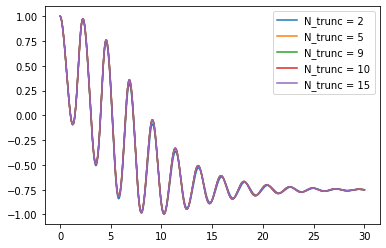

In [51]:
for i, N_trunc in enumerate(N_trunc_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_trunc = "+str(N_trunc))
plt.legend()
plt.show()

# HOMPS: Convergence in N_trunc (with noise)

In [11]:
N_steps = 2000
N_trunc_list = [2, 5, 9]
N_terms = 15
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')

In [12]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4'
}
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc_list[0], options)
zts_debug = my_homps.generator.sample_process()

In [13]:
psis_N_trunc = []

for N_trunc in N_trunc_list:
    print("Computing N_trunc =", N_trunc)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_trunc.append(my_homps.compute_realizations(1, zts_debug=zts_debug))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_trunc = 2
took 68.511559009552 seconds.
Computing N_trunc = 5
took 236.39711666107178 seconds.
Computing N_trunc = 9
took 581.5351011753082 seconds.


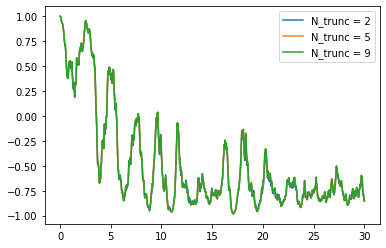

In [14]:
for i, N_trunc in enumerate(N_trunc_list[:3]):
    sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_trunc = "+str(N_trunc))
plt.legend()
plt.show()

# HOMPS: Convergence in eps (without noise)

In [28]:
N_steps = 2000
N_trunc = 9
eps_list = [1.e-3, 1.e-4, 1.e-5, 1.e-6]
N_terms = 15
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')

In [29]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
}

In [30]:
psis_eps = []
average_bond_dims = []
max_bond_dims = []

for eps in eps_list:
    print("Computing eps =", eps)
    start = time.time()
    options['eps'] = eps
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_eps.append(my_homps.compute_realizations(1, collect_debug_info=True))
    bond_dims = my_homps.debug_info['bond_dims'][0]
    average_bond_dims.append(np.mean(bond_dims, axis=1))
    max_bond_dims.append(np.max(bond_dims, axis=1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing eps = 0.001
took 92.89774823188782 seconds.
Computing eps = 0.0001
took 163.22085881233215 seconds.
Computing eps = 1e-05
took 679.8091742992401 seconds.
Computing eps = 1e-06
took 1099.9753015041351 seconds.


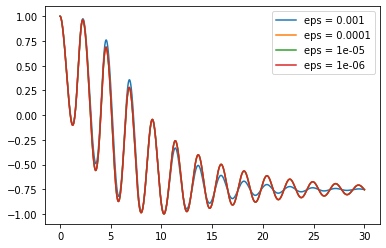

In [31]:
for i, eps in enumerate(eps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_eps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="eps = "+str(eps))
plt.legend()
plt.show()

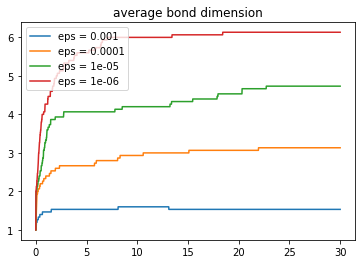

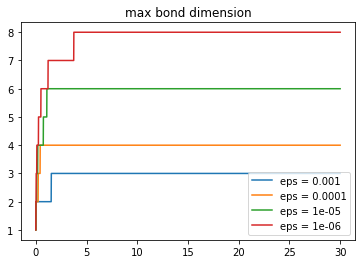

In [32]:
for i, eps in enumerate(eps_list):
    plt.plot(np.linspace(0, duration, N_steps), average_bond_dims[i], label="eps = "+str(eps))
plt.legend()
plt.title("average bond dimension")
plt.show()

for i, eps in enumerate(eps_list):
    plt.plot(np.linspace(0, duration, N_steps), max_bond_dims[i], label="eps = "+str(eps))
plt.legend()
plt.title("max bond dimension")
plt.show()

# HOMPS: Convergence in eps (with noise)

In [30]:
N_steps = 1500
N_trunc = 9
eps_list = [1.e-3, 1.e-4, 1.e-5, 1.e-6]
N_terms = 13
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')

In [31]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
}

In [32]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
zts_debug = my_homps.generator.sample_process()

In [33]:
psis_eps = []
average_bond_dims = []
max_bond_dims = []

for eps in eps_list:
    print("Computing eps =", eps)
    start = time.time()
    options['eps'] = eps
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_eps.append(my_homps.compute_realizations(1, collect_debug_info=True, zts_debug=zts_debug))
    bond_dims = my_homps.debug_info['bond_dims'][0]
    average_bond_dims.append(np.mean(bond_dims, axis=1))
    max_bond_dims.append(np.max(bond_dims, axis=1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing eps = 0.001
took 63.79745650291443 seconds.
Computing eps = 0.0001
took 135.9018452167511 seconds.
Computing eps = 1e-05
took 410.8750331401825 seconds.
Computing eps = 1e-06
took 762.2229166030884 seconds.


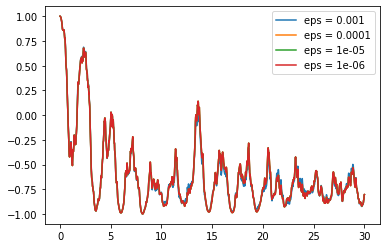

In [34]:
for i, eps in enumerate(eps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_eps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="eps = "+str(eps))
plt.legend()
plt.show()

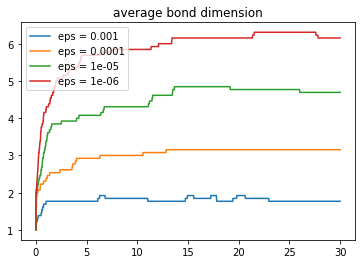

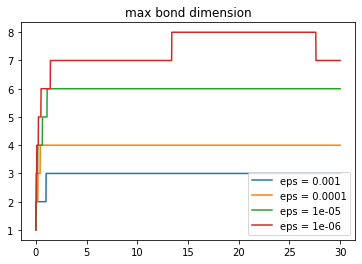

In [35]:
for i, eps in enumerate(eps_list):
    plt.plot(np.linspace(0, duration, N_steps), average_bond_dims[i], label="eps = "+str(eps))
plt.legend()
plt.title("average bond dimension")
plt.show()

for i, eps in enumerate(eps_list):
    plt.plot(np.linspace(0, duration, N_steps), max_bond_dims[i], label="eps = "+str(eps))
plt.legend()
plt.title("max bond dimension")
plt.show()

# HOMPS: Convergence in N_terms (without noise)

In [55]:
N_steps = 2000
N_trunc = 9
N_terms_list = [10, 15, 20]

In [56]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
}

Computing N_terms = 10
took 60.555630922317505 seconds.
bond dims at the last iteration:
[2. 4. 2. 2. 1. 1. 1. 1. 1. 1.]


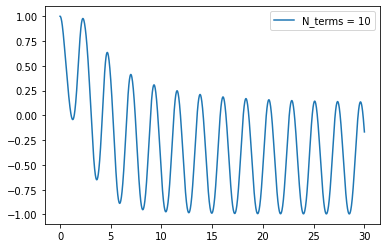

Computing N_terms = 15
took 92.13174653053284 seconds.
bond dims at the last iteration:
[2. 3. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]


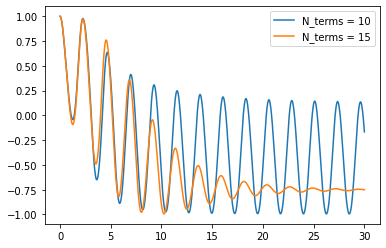

Computing N_terms = 20
took 147.58490228652954 seconds.
bond dims at the last iteration:
[2. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]


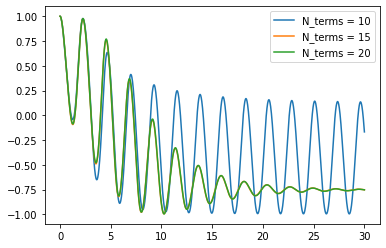

In [57]:
psis_N_terms = []
bond_dims = []

def plot_progress(i):
    print("bond dims at the last iteration:")
    print(bond_dims[-1][-1])
    for j in range(i+1):
        sigma_zs = compute_exp_val_nonlinear(psis_N_terms[j], sigma_z)
        plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_terms = "+str(N_terms_list[j]))
    plt.legend()
    plt.show()

for i, N_terms in enumerate(N_terms_list):
    print("Computing N_terms =", N_terms)
    start = time.time()
    g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_terms.append(my_homps.compute_realizations(1, collect_debug_info=True))
    bond_dims.append(my_homps.debug_info['bond_dims'][0])
    end = time.time()
    print("took", end-start, "seconds.")
    plot_progress(i)

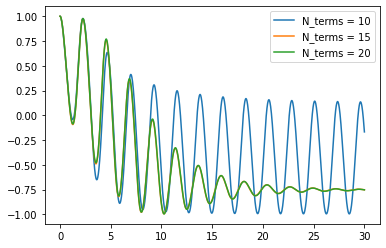

In [59]:
for i, N_terms in enumerate(N_terms_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_terms[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_terms = "+str(N_terms))
plt.legend()
plt.show()

# HOMPS: Convergence in N_terms (with noise)

In [16]:
from src.util import noise_generator

In [13]:
N_steps = 2000
N_trunc = 9
N_terms_list = [13, 15, 17, 20]

In [14]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
}

Computing N_terms = 13
took 69.7696545124054 seconds.
bond dims at the last iteration:
[2. 3. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1.]


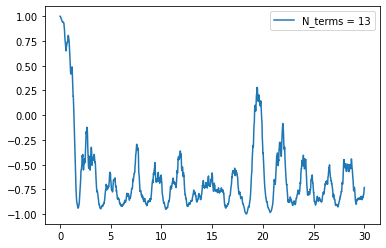

Computing N_terms = 15
took 82.36278438568115 seconds.
bond dims at the last iteration:
[2. 3. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]


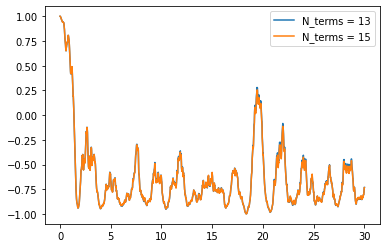

Computing N_terms = 17
took 105.91591668128967 seconds.
bond dims at the last iteration:
[2. 4. 3. 3. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]


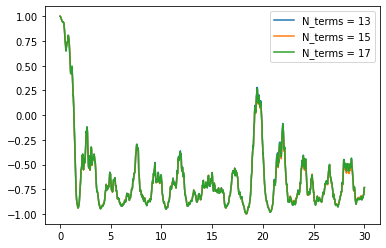

Computing N_terms = 20
took 177.7173252105713 seconds.
bond dims at the last iteration:
[2. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]


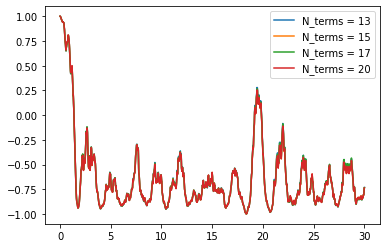

In [18]:
psis_N_terms = []
bond_dims = []
g, w = debye_spectral_density.get_debye_coefficients(N_terms_list[-1], T, gamma, eta, mode="pade")
alpha = lambda tau : bath_correlation_function.alpha(tau, g, w)
generator = noise_generator.ColoredNoiseGenerator_FourierFiltering(alpha, 0, duration)
generator.initialize(2*N_steps)
zts_debug = generator.sample_process()

def plot_progress(i):
    print("bond dims at the last iteration:")
    print(bond_dims[-1][-1])
    for j in range(i+1):
        sigma_zs = compute_exp_val_nonlinear(psis_N_terms[j], sigma_z)
        plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_terms = "+str(N_terms_list[j]))
    plt.legend()
    plt.show()

for i, N_terms in enumerate(N_terms_list):
    print("Computing N_terms =", N_terms)
    start = time.time()
    g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_terms.append(my_homps.compute_realizations(1, collect_debug_info=True, zts_debug=zts_debug))
    bond_dims.append(my_homps.debug_info['bond_dims'][0])
    end = time.time()
    print("took", end-start, "seconds.")
    plot_progress(i)

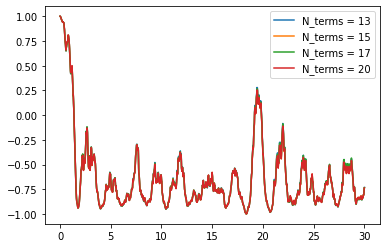

In [19]:
for i, N_terms in enumerate(N_terms_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_terms[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_terms = "+str(N_terms))
plt.legend()
plt.show()

# HOMPS: RK4 vs TDVP (with noise)

In [24]:
N_steps = 2000
N_trunc = 9
N_terms = 13
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')
alpha = lambda tau : bath_correlation_function.alpha(tau, g, w)
generator = noise_generator.ColoredNoiseGenerator_FourierFiltering(alpha, 0, duration)
generator.initialize(2*N_steps)

In [22]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
}

In [33]:
#print("Computing RK4")
#options['method'] = 'RK4'
#start = time.time()
#my_homps_RK4 = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
#psis_RK4 = my_homps_RK4.compute_realizations(1, collect_debug_info=True, zts_debug=zts_debug)
#end = time.time()
#print("took", end-start, "seconds.")

print("Computing TDVP2")
options['method'] = 'TDVP2'
start = time.time()
my_homps_TDVP2 = homps.HOMPS_Engine(g, w, h, L, duration, 2*N_steps, N_trunc, options)
psis_TDVP2 = my_homps_TDVP2.compute_realizations(1, collect_debug_info=True, zts_debug=zts_debug)
end = time.time()
print("took", end-start, "seconds.")

Computing TDVP2
took 233.17812538146973 seconds.


In [34]:
sigma_zs_RK4 = compute_exp_val_nonlinear(psis_RK4, sigma_z)
sigma_zs_TDVP2 = compute_exp_val_nonlinear(psis_TDVP2, sigma_z)

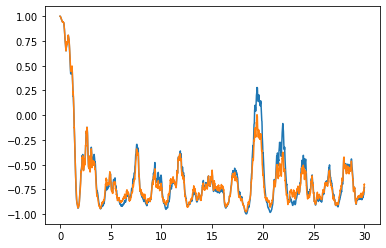

In [36]:
plt.plot(np.linspace(0, 30, N_steps), sigma_zs_RK4, label="RK4")
plt.plot(np.linspace(0, 30, 2*N_steps), sigma_zs_TDVP2, label="TDVP2")
plt.show()